In [204]:
%reload_ext cypher
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
import datetime
import locale
import math 

In [172]:
def highlight_cells(row):
    color = ''
    if ('Section' in row.index.values and row['Section'] == 'Total') or ('Title' in row.index.values and row['Title'] == 'Total') or ('Months' in row.index.values and (row['Months'] == 'Total' or row['Months'] == 'Average')) :
        color = 'yellow'    
    background = ['background-color: {}'.format(color) for _ in row]
    return background

## Cantidad total de artículos

In [56]:
%cypher MATCH (n:Article) RETURN count(n) as Total

1 rows affected.


Total
2055


## Cantidad de artículos por sección

In [57]:
df = %%cypher MATCH (n:Article) RETURN n.section as Section, count(n.hid) as Number ORDER BY Number DESC
df = df.get_dataframe()
df = df.set_index(['Section'])
df.loc['Total'] = df['Number'].sum()
df = df.reset_index()
df.style.apply(highlight_cells, axis=1)

19 rows affected.


,Section,Number
0,Silla Nacional,431
1,La Silla Caribe,179
2,La Silla Santandereana,170
3,Red de la Educación,159
4,Red de la Paz,158
5,Red Líder,130
6,Red Cachaca,111
7,Opinión,100
8,Red de las Mujeres,94
9,Red Rural,85


## Cantidad de artículos en secciones seleccionadas

In [58]:
%cypher MATCH (n:Article) SET n.valid = False 
%cypher MATCH (n:Article) WHERE n.section = 'Silla Nacional' or n.section ='La Silla Caribe'or n.section = 'La Silla Santandereana'or n.section = 'Red de la Paz'or n.section = 'Opinión'or n.section = 'Red Caribe'or n.section = 'La Silla'or n.section = 'La Silla Pacífico'or n.section = 'Hágame el cruce' SET n.valid = True

2055 properties set.
1010 properties set.


[]

In [61]:
pdf = %%cypher MATCH (n:Article) WHERE n.valid = True RETURN n.section as Section, count(n.hid) as Number ORDER BY Number DESC
pdf = pdf.get_dataframe() 
pdf = pdf.set_index(['Section'])
pdf.loc['Total'] = pdf['Number'].sum()
pdf = pdf.reset_index()
pdf.style.apply(highlight_cells, axis=1)

7 rows affected.


,Section,Number
0,Silla Nacional,431
1,La Silla Caribe,179
2,La Silla Santandereana,170
3,Opinión,100
4,La Silla,62
5,La Silla Pacífico,43
6,Hágame el cruce,25
7,Total,1010


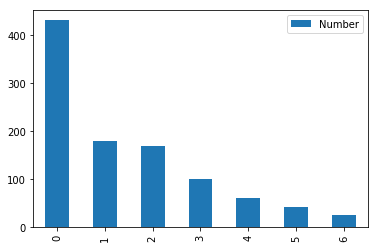

In [62]:
pdf = pdf.drop([7])
pdf.plot(kind='bar')

## Secciones más visitadas

7 rows affected.


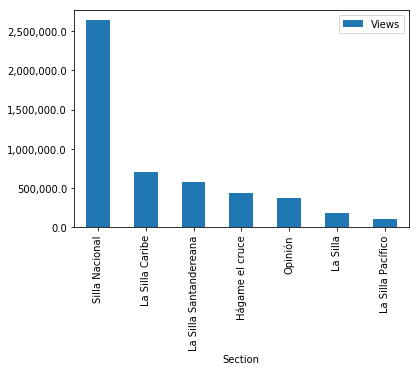

In [63]:
dfV = %%cypher MATCH (n:Article) WHERE n.valid = True RETURN n.section as Section, sum(toInt(n.no_views)) as Views ORDER BY Views DESC 
dfV = dfV.get_dataframe() 
dfV = dfV.set_index('Section')
ax = dfV.plot(kind='bar')
vals = ['{:,}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(vals)

In [64]:
dfV['Views'] = dfV['Views'].map('{:,}'.format)
dfV.loc['Total'] = dfV['Views'].str.replace(",", "").astype(int).sum()
dfV = dfV.reset_index()
dfV.style.apply(highlight_cells, axis=1)

,Section,Views
0,Silla Nacional,"2,637,606"
1,La Silla Caribe,"703,816"
2,La Silla Santandereana,"574,546"
3,Hágame el cruce,"435,114"
4,Opinión,"379,772"
5,La Silla,"187,709"
6,La Silla Pacífico,"105,508"
7,Total,5024071


## 50 Artículos más visitados

In [103]:
df50 = %%cypher MATCH (n:Article) WHERE n.valid = True RETURN n.hid as ID, n.title as Title, n.date as Date, n.section as Section, toInt(n.no_views) as Views ORDER BY Views DESC LIMIT 50
df50 = df50.get_dataframe().set_index(['Title'])
df50.loc['Total'] = ['-', '-', '-', df50['Views'].sum()]
df50['Views'] = df50['Views'].map('{:,}'.format)
df50.reset_index().style.apply(highlight_cells, axis=1)

50 rows affected.


,Title,ID,Date,Section,Views
0,¿Vicky inaugura una nueva era del periodismo nacional?,h1312,16 de Febrero de 2016,Silla Nacional,"117,555"
1,Las Farc ha cedido más que el Gobierno en La Habana,h1536,27 de Junio de 2016,Hágame el cruce,"112,805"
2,"""Quiero decirles a los que promocionan la guerra, que no tienen ni idea de lo que es""",h1520,28 de Septiembre de 2016,Silla Nacional,"81,781"
3,"Las propuestas del No, comparadas y desmenuzadas",h1538,15 de Octubre de 2016,Hágame el cruce,"69,711"
4,¿Qué es una ideología de género?,h1638,11 de Agosto de 2016,Opinión,"54,985"
5,Detector de mentiras a Uribe sobre el acuerdo final,h976,28 de Agosto de 2016,Silla Nacional,"38,933"
6,"“¡Quién diría que creer en la PAZ costara tanto!""",h213,22 de Septiembre de 2016,Silla Nacional,"37,551"
7,El 'papayazo' de Gina,h557,11 de Agosto de 2016,Silla Nacional,"37,429"
8,Así son los colombianos de Panamá Papers,h607,15 de Mayo de 2016,Hágame el cruce,"36,682"
9,Vargas Lleras ya no es el candidato a vencer en 2018,h365,03 de Octubre de 2016,Silla Nacional,"34,690"


# Frecuencia de publicaciones

## Cantidad de publicaciones mensuales (Total y Promedio al final)

In [256]:
dfTimes = %%cypher MATCH (n:Article) WHERE n.valid = True RETURN n.hid as ID, n.date as Date
dfTimes = dfTimes.get_dataframe()
times = dfTimes.Date.apply(lambda x: datetime.datetime.strptime(x.replace('de Enero de', '01').replace('de Febrero de', '02').replace('de Marzo de', '03').replace('de Abril de', '04').replace('de Mayo de', '05').replace('de Junio de', '06').replace('de Julio de', '07').replace('de Agosto de', '08').replace('de Septiembre de', '09').replace('de Octubre de', '10').replace('de Noviembre de', '11').replace('de Diciembre de', '12'), "%d %m %Y") if type(x) == str else None)
dfTimes ['Date'] =  times
dfTimesMensuales = dfTimes.groupby(dfTimes['Date'].dt.month).agg({'ID':'count'})
dfTimesMensuales.loc['Average'] =  math.ceil(dfTimesMensuales['ID'].mean()*100/100)
dfTimesMensuales.loc['Total'] =  dfTimesMensuales.drop(['Average'])['ID'].sum()
dfTimesMensuales.columns = ['Number']
dfTimesMensuales.index.rename('Months', inplace=True)
dfTimesMensuales = dfTimesMensuales.rename({1:'Enero', 2:'Febrero', 3:'Marzo',4:'Abril', 5:'Mayo', 6:'Junio', 7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'})
dfTimesMensuales = dfTimesMensuales.reset_index()
dfTimesMensuales.style.apply(highlight_cells, axis=1)

1010 rows affected.


,Months,Number
0,Enero,63
1,Febrero,74
2,Marzo,44
3,Abril,74
4,Mayo,71
5,Junio,84
6,Julio,77
7,Agosto,93
8,Septiembre,102
9,Octubre,110


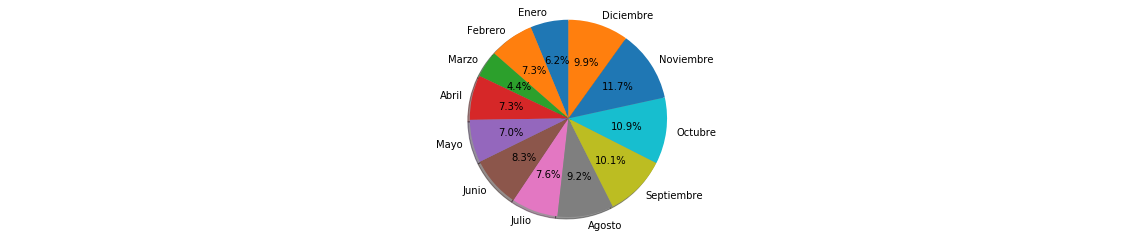

In [257]:
dfTimesMensuales = dfTimesMensuales.drop([12,13])

labels = dfTimesMensuales['Months'].values
sizes = dfTimesMensuales['Number'].values
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

## 10 días con mayor cantidad de publicaciones

##### Hay muchos más días con 6 publicaciones , por eso seleccioné solo los 10 primeros ( ver el próximo reporte para la cantidad de días por número de publicaciones)

In [208]:
dfTimesTopDays = dfTimes.groupby(dfTimes['Date']).agg({'ID':'count'})
dfTimesTopDays.columns = ['Cantidad']
dfTimesTopDays = dfTimesTopDays.sort_values(by='Cantidad', ascending=False)
dfTimesTopDays.head(10)

,Cantidad
Date,
2016-10-24,8
2016-09-28,7
2016-11-08,7
2016-11-28,7
2016-10-21,6
2016-12-16,6
2016-12-15,6
2016-06-14,6
2016-12-12,6


## Frecuencia diaria de publicaciones 

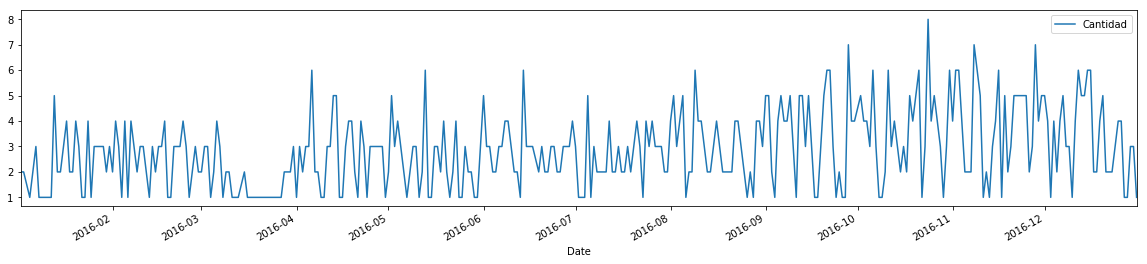

In [223]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 4.0)
dfTimesTopDays.plot()

## Cantidad de días por número de publicaciones

In [218]:
dfDias = dfTimesTopDays.reset_index().groupby(['Cantidad']).agg({'Date':'count'})
dfDias.index.rename('Cantidad de publicaciones', inplace=True)
dfDias.columns= ['Cantidad de días']
dfDias

,Cantidad de días
Cantidad de publicaciones,
1,71
2,82
3,89
4,53
5,33
6,17
7,3
8,1


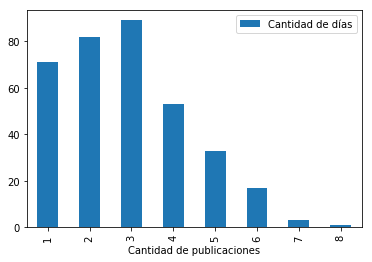

In [220]:
dfDias.plot(kind='bar')

## Promedio de publicaciones diarias

In [219]:
math.ceil(dfTimesTopDays['Cantidad'].mean()*100/100)

3

# Autores 

   ## Top 20 autores que más escribieron

In [244]:
dfAuthor = %%cypher MATCH p=(n:Author)-[r:WRITES]->({valid:True}) RETURN count(p) as Articles, n.name as Authors order by Articles DESC LIMIT 20
dfAuthor = dfAuthor.get_dataframe().set_index('Authors')
dfAuthor

20 rows affected.


,Articles
Authors,
Jineth Prieto,111
Juan Esteban Lewin,109
Juanita León,94
LaSillaVacia.com,92
\nLaSillaVacia.com,92
Juanita Vélez,78
Laura Ardila Arrieta,67
Natalia Arenas,66
Antonio Canchila García,43
